In [1]:
# load libraries
import numpy as np
import scipy.io as sio
import scipy.signal as sig
from tvb.simulator.lab import *
import matplotlib.pyplot as plt
import matplotlib
import os
import multiprocessing as mp 
from matplotlib.gridspec import GridSpec

   INFO  log level set to INFO


# Introduction

In [2]:
# Here we present an approach to link molecular of Alzheimer's disease (AD) to large-scale simulations of The Virtual Brain
# Therefore, regional burden of Amyloid beta (Abeta) is derived from AV-45 positrone emission tomography (PET)
# A cause-and-effect model defines the inhibitory rate of each region as a function of the Abeta burden
# This leads to an AD-specific slowing in local field potentials and EEG

# Preprint of original publication can be found here: https://www.biorxiv.org/content/10.1101/600205v2

# Please cite as: 
# Stefanovski, L., P. Triebkorn, A. Spiegler, M.-A. Diaz-Cortes, A. Solodkin, V. Jirsa, 
# R. McIntosh and P. Ritter; for the Alzheimer's disease Neuromigang Initiative (2019). 
# "Linking molecular pathways and large-scale computational modeling to assess candidate 
# disease mechanisms and pharmacodynamics in Alzheimer's disease." bioRxiv: 600205.

# Empirical data were obtained from the Alzheimer’s Disease Neuroimaging Initiative (ADNI) database 
# (adni.loni.usc.edu). The ADNI was launched in 2003 as a public-private partnership, 
# led by Principal Investigator Michael W. Weiner. The primary goal of ADNI has been to test whether 
# serial MRI, PET, other biological markers, and clinical and neuropsychological assessment can be 
# combined to measure the progression of MCI and early AD. For up-to-date information, see www.adni-info.org. 
# ADNI acknowledgements: 
# http://adni.loni.usc.edu/wp-content/themes/freshnews-dev-v2/documents/policy/ADNI_Acknowledgement_List%205-29-18.pdf'

# Data source

In [3]:
# set path to the educase folder where this notebook 
# and all the input data necessary for the simulation can be found
# NOTE: we provide an artificial surrogate dataset that is created by noise 
# and important properties of the empirical data in ADNI
# For the original dataset of ADNI, please apply for access to ADNI-3:
# http://adni.loni.usc.edu/data-samples/access-data/

# necessary data is:
# 1 structural connectivity matrix in .txt format
# for each subject 3 arrays with Abeta SUVR for left and right hemisphere and for subcortical areas
# for each subject 1 leadfield matrix
educase_folder = "/Users/leon/Desktop/Educase_ADNI_surrogate"


# Cause-and-effect model for Abeta: sigmoidal transfer function

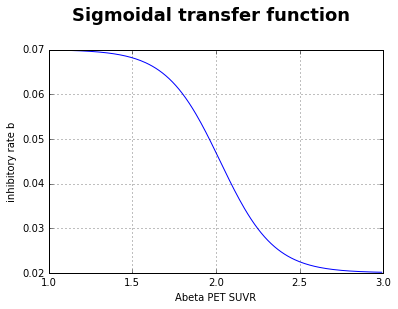

In [4]:
# Evidence for local effects of Abeta to inhibitory interneurons, e.g.: 
# Ren et al. 2018 Scientific Reports: https://www.nature.com/articles/s41598-017-18729-5
# Ulrich 2015 J Neurosci: http://www.jneurosci.org/content/jneuro/35/24/9205.full.pdf
# Ripoli et al. 2014 J Neurosci: http://www.jneurosci.org/content/34/38/12893
# We define here the local inhibitory rate b as a function of Abeta burden:

# min_val is the lower asymptote of the sigmoid with a inhibitory time constant tau_i = 1/b = 50 ms
# max_val is the differnece between lower and upper asymptote of the sigmoid
# max_val + min_val is the upper asymptote of the sigmoid at tau_i = 1/b = 14.29 ms
# abeta_max is the 95th perecentile of Abeta SUVRs in the original study population
# abeta_off is the cut-off SUVR from which on the sigmoid decreases, 
# see Jack et al. 2014 Lancet Neurol: https://www.ncbi.nlm.nih.gov/pubmed/25201514

def transform_abeta_exp(abeta, max_val  = 0.05, min_val = 0.02, abeta_max = 2.65, abeta_off = 1.4):
    #k   = 1.5       # steepness of the curve
    x_0       = (abeta_max - abeta_off) / 2  + abeta_off      # x value of  sigmoid midpoint
    k = np.log( max_val / ((min_val+0.001) - min_val) -1) / (abeta_max - x_0)
    return  max_val / (1 + np.exp(k * (abeta - x_0) )) + min_val

# visualize 
x = np.arange(1.,3,0.01)
plt.plot(x, transform_abeta_exp(x))
plt.xlabel("Abeta PET SUVR")
plt.ylabel("inhibitory rate b")
plt.suptitle("Sigmoidal transfer function", fontweight="bold", fontsize="18", y = 1.05)
plt.grid()
plt.show()

# Load individual Abeta PET SUVRs

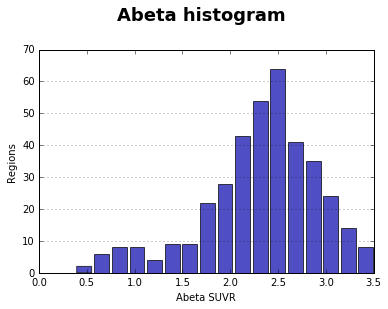

In [8]:
# select the subject you want to simulate
DX = "MCI" # one of AD, MCI or HC
modality="Amyloid"
pet_path=educase_folder+"/"+DX
RH_pet = np.loadtxt(pet_path+"/"+DX+"_RH.txt")
LH_pet = np.loadtxt(pet_path+"/"+DX+"_LH.txt")
subcort_pet = np.loadtxt(pet_path+"/"+DX+"_subcortical.txt")
abeta_burden = np.concatenate((LH_pet,RH_pet,subcort_pet))

n, bins, patches = plt.hist(abeta_burden, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Abeta SUVR')
plt.ylabel('Regions')
plt.suptitle("Abeta histogram", fontweight="bold", fontsize="18", y = 1.05)
plt.show()

# Configure Simulator

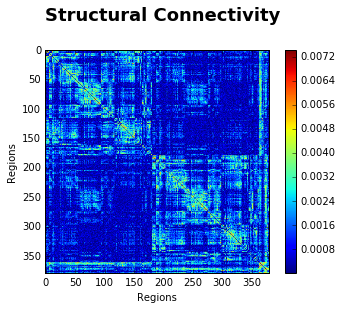

In [9]:
# load SC
SCnorm = np.loadtxt(educase_folder+"/avg_healthy_normSC_mod.txt")

plt.imshow(np.asarray(SCnorm))
plt.colorbar()
plt.xlabel("Regions")
plt.ylabel("Regions")
plt.suptitle("Structural Connectivity", fontweight="bold", fontsize="18", y = 1.05)
plt.show()

In [10]:
# load leadfield matrix
lf_mat = sio.loadmat(educase_folder+"/"+DX+"/leadfield.mat")["lf_sum"]

#b = 0.07 # default Jansen-Rit inhibitory membrane constant
b = transform_abeta_exp(abeta_burden)

    
init = np.random.rand(4000,6,SCnorm.shape[0],1);

mu = 0.1085
jrm = models.JansenRit(v0=6., mu=mu, p_max=mu, p_min=mu, 
                       b = b,
                       variables_of_interest=['y1 - y2'])


# omitting any time delay between regions
white_matter = connectivity.Connectivity(weights=SCnorm, tract_lengths=np.zeros(SCnorm.shape))

# set up the simulator
# adjust the simulation_length to your needs/ available computation time
# in the paper a simulation_length of 120000 was used
# but only the 2nd minute was used in the analysis to cut out possible transients 
sim = simulator.Simulator(  connectivity=white_matter, 
                            model=jrm,
                            coupling=coupling.SigmoidalJansenRit(a=0),
                            integrator=integrators.HeunDeterministic(dt=0.5),
                            conduction_speed=100,
                            monitors=monitors.SubSample(period=5),
                            initial_conditions = init,
                            simulation_length=4000.0)
sim.configure();

# Run simulation

In [11]:
# if you whish to save the simulated timeseries 
# set save_timeseries_to_file to True and declare a path/folder in save_path
save_timeseries_to_file = False
save_path = ""

In [12]:
def run_sim(global_coupling):
    sim.coupling.a = global_coupling

    subs = sim.run()
    PSP = np.squeeze(subs[0][1])[400:,:] # cut out first part of simulation due to possible transients
    
    ##### Analyze PSP
    # analyze signal, get baseline and frequency
    psp_baseline  = PSP.mean(axis=0)
    psp_f, psp_pxx      = sig.periodogram(PSP[:,:]-psp_baseline, fs=200, nfft=1024, axis=0)
    psp_Pxx    = psp_pxx.T
    psp_peak_freq = psp_f[np.argmax(psp_pxx.T, axis=1)]
    
    ##### Analyze EEG
    # generate EEG by multiplication of PSP with lf_mat
    EEG = lf_mat.dot(PSP.T).T # EEG shape [n_samples x n_eeg_channels]
    
    # reference is mean signal, tranposing because trailing dimension of arrays must agree 
    EEG = (EEG.T - EEG.mean(axis=1).T).T
    
    # analyze signal, get baseline and frequency
    eeg_baseline = EEG.mean(axis=0)
    EEG = EEG - EEG.mean(axis=0)  # center EEG
    
    eeg_f, eeg_pxx = sig.periodogram(EEG, fs=200, nfft=1024, axis=0) 
    eeg_Pxx        = eeg_pxx.T
    eeg_peak_freq  = eeg_f[np.argmax(eeg_pxx.T, axis=1)]
    
    if save_timeseries_to_file :
        # save results     
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        file_name=save_path+"/"+DX+"_gc_"+str(global_coupling)+".mat"
        sio.savemat(file_name,mdict={"PSP":PSP})
        
    return (global_coupling,psp_baseline, psp_peak_freq, eeg_peak_freq)

In [13]:
# define global coupling range to explore in simulation
# in the original study a range from 0 to 600 with steps of 3 was explored
# NOTE: Too many steps will take very long time when running the script on a local computer
gc_range = np.arange(0,600,30)


# run simulation in parallel - be sure that your computer has enough cores
n_cores = 4 # specify number of cores which should be used in parallel 
p = mp.Pool(processes=n_cores)
results = p.map(run_sim, gc_range)
p.close()

# Display results

In [14]:
# concatenate the output from the parallel loop
psp_baseline  = results[0][1]
psp_peak_freq = results[0][2]
eeg_peak_freq = results[0][3]

for i in range(len(results)-1):
    psp_baseline  = np.vstack((psp_baseline,results[i+1][1]))
    psp_peak_freq = np.vstack((psp_peak_freq,results[i+1][2]))
    eeg_peak_freq = np.vstack((eeg_peak_freq,results[i+1][3]))

In [15]:
# define colormap
lower = plt.cm.jet(np.linspace(0,1,200))
colors = np.vstack(([0,0,0,0],lower))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('test', colors)
tmp = np.array([26,16,11,6])

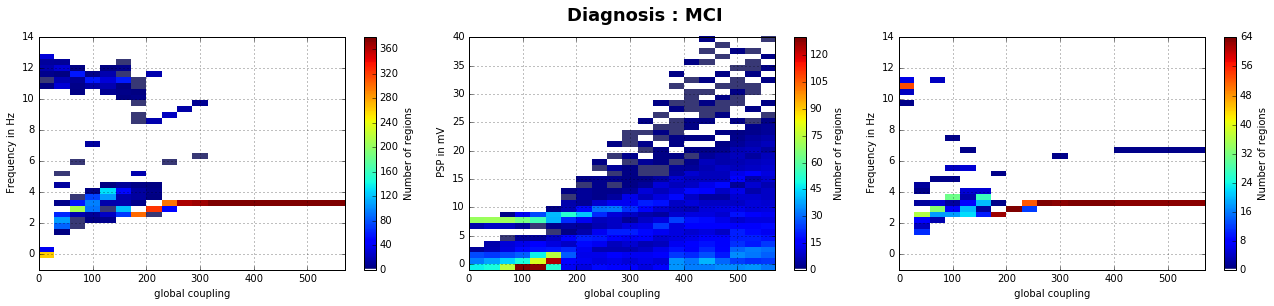

In [16]:
# plot results
plt.figure(figsize=(18, 4))
grid = GridSpec(nrows=1, ncols=3)
x_coord       = gc_range.repeat(379)
x_coord_eeg   = gc_range.repeat(64)

plt.suptitle("Diagnosis : "+DX, fontweight="bold", fontsize="18", y = 1.05)

# plot psp frequency
plt.subplot(grid[0,0])
plt.hist2d(x_coord, psp_peak_freq.flatten(), bins=[len(gc_range),40], cmap=tmap,
          range=[[np.min(gc_range),np.max(gc_range)],[-1,14]] ) #, vmax=100)
plt.colorbar(label="Number of regions")
plt.grid()
plt.ylabel(' Frequency in Hz')
plt.xlabel(' global coupling ')

# plot psp baseline
plt.subplot(grid[0,1])
plt.hist2d(x_coord, psp_baseline.flatten(), bins=[len(gc_range),40], cmap=tmap,
          range=[[np.min(gc_range),np.max(gc_range)],[-1,40]])#, vmax=100)
plt.colorbar(label="Number of regions")
plt.grid()
plt.ylabel(' PSP in mV')
plt.xlabel(' global coupling ')

# plot eeg frequency
plt.subplot(grid[0,2])
plt.hist2d(x_coord_eeg, eeg_peak_freq.flatten(), bins=[len(gc_range),40], cmap=tmap,
          range=[[np.min(gc_range),np.max(gc_range)],[-1,14]] )#, vmax=100)
plt.colorbar(label="Number of regions")
plt.grid()
plt.ylabel(' Frequency in Hz')
plt.xlabel(' global coupling ')

plt.tight_layout()  

plt.show()